In [1]:
import xml.etree.ElementTree as ET
import os
from os import listdir, getcwd
from os.path import join

#Get current directory. We assume we have VOCDevkit in current working directory
wd = getcwd()

#Open file to write the CSV data
csv_file = open('VOCDev.csv', 'w')
#Insert the header
csv_file.write('year,imageset,imagename,imagewidth,imageheight,class,difficulty,pose,truncated,xmin,xmax,ymin,ymax\n')

sets = [('2012', 'train'), ('2012', 'val'), ('2007', 'train'), ('2007', 'val'), ('2007', 'test')]

for year, image_set in sets:
    image_ids = open('VOCdevkit/VOC%s/ImageSets/Main/%s.txt' % (year, image_set)).read().strip().split()
    for image_id in image_ids:
        
        #Open up the annotation file
        ann_file = open('VOCdevkit/VOC%s/Annotations/%s.xml' % (year, image_id))
        tree = ET.parse(ann_file)
        root = tree.getroot()
        size = root.find('size')
        w = int(size.find('width').text)
        h = int(size.find('height').text)
        
        for obj in root.iter('object'):
            cls = obj.find('name').text
            difficult = obj.find('difficult').text
            pose = obj.find('pose').text
            truncated = obj.find('truncated').text
            xmlbox = obj.find('bndbox')
            xmin = xmlbox.find('xmin').text
            xmax = xmlbox.find('xmax').text
            ymin = xmlbox.find('ymin').text
            ymax = xmlbox.find('ymax').text
            
            csv_file.write('%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s\n' % 
                       (year, image_set, image_id, w, h, cls, difficult, 
                        pose, truncated, xmin, xmax, ymin, ymax))
        ann_file.close()
csv_file.close()

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('VOCDev.csv')
df.head()

,year,imageset,imagename,imagewidth,imageheight,class,difficulty,pose,truncated,xmin,xmax,ymin,ymax
0,2012,train,2008_000008,500,442,horse,0,Left,0,53,471,87,420
1,2012,train,2008_000008,500,442,person,0,Unspecified,1,158,289,44,167
2,2012,train,2008_000015,500,327,bottle,0,Unspecified,1,270,378,1,176
3,2012,train,2008_000015,500,327,bottle,0,Unspecified,1,57,164,1,150
4,2012,train,2008_000019,480,272,dog,0,Unspecified,0,139,372,2,197


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62199 entries, 0 to 62198
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   year         62199 non-null  int64 
 1   imageset     62199 non-null  object
 2   imagename    62199 non-null  object
 3   imagewidth   62199 non-null  int64 
 4   imageheight  62199 non-null  int64 
 5   class        62199 non-null  object
 6   difficulty   62199 non-null  int64 
 7   pose         62199 non-null  object
 8   truncated    62199 non-null  int64 
 9   xmin         62199 non-null  int64 
 10  xmax         62199 non-null  int64 
 11  ymin         62199 non-null  int64 
 12  ymax         62199 non-null  int64 
dtypes: int64(9), object(4)
memory usage: 6.2+ MB


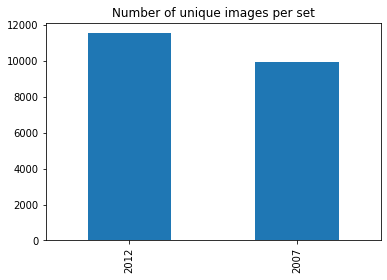

In [4]:
#Count the number of unique images for year 2007 and 2012
df_imgUnique=df[['year','imagename','imageset', 'class']].drop_duplicates('imagename')
df_imgUnique['year'].value_counts().plot(kind='bar')
plt.title('Number of unique images per set')
plt.show()

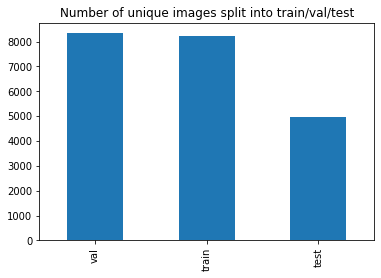

In [5]:
#Check the number of images split for train/val/test
df_imgUnique['imageset'].value_counts().plot(kind='bar')
plt.title('Number of unique images split into train/val/test')
plt.show()

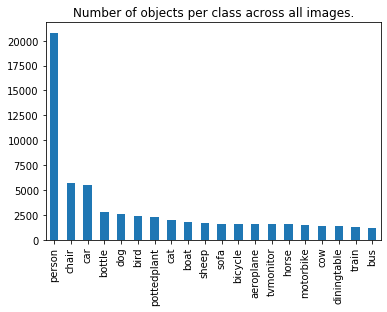

In [6]:
#Check the number of objects per class
#Note that we are using the df and not df_imgUnique. Each image may contain objects of different class
df['class'].value_counts().plot(kind='bar')
plt.title('Number of objects per class across all images.')
plt.show()

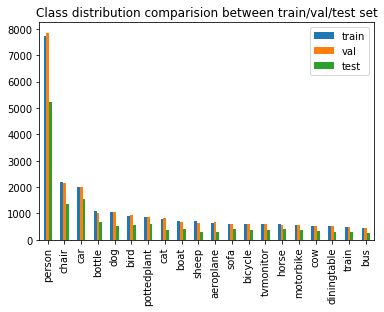

In [7]:
#Check out the class distribution between 2007 and 2012
df_train = df[df['imageset']=='train']
objCountTrain = df_train['class'].value_counts().rename('train')

df_val = df[df['imageset']=='val']
objCountVal = df_val['class'].value_counts().rename('val')

df_test = df[df['imageset']=='test']
objCountTest = df_test['class'].value_counts().rename('test')


df_objCount = pd.concat([objCountTrain, objCountVal, objCountTest], axis=1)
df_objCount.plot(kind='bar')
plt.title('Class distribution comparision between train/val/test set')
plt.show()



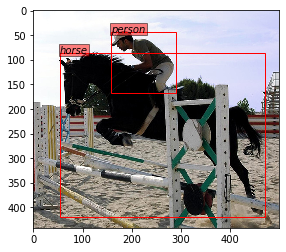

In [8]:
import matplotlib.image as mpimg
import matplotlib.patches as patches

objToInspect = 1

object = df.iloc[objToInspect]

imgPath = '%s/VOCdevkit/VOC%s/JPEGImages/%s.jpg' % (wd, object['year'], object['imagename'])
img = mpimg.imread(imgPath)

fig,ax = plt.subplots(1)

# Display the image
ax.imshow(img)
df_boxes = df[df['imagename']==object['imagename']]
boxes = df_boxes[['class','xmin','xmax','ymin','ymax']].values.tolist()

for classname, xmin, xmax, ymin, ymax in boxes: 
    # Draw bounding box
    rect = patches.Rectangle((xmin,ymin),xmax-xmin,ymax-ymin,linewidth=1,edgecolor='r',facecolor='none')
    ax.text(xmin, ymin, classname, style='italic',
        bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 1})
    ax.add_patch(rect)

imgplot = plt.show()